<a href="https://colab.research.google.com/github/hecshzye/6DoF_object_pose_estimation/blob/main/notebook/6D-pose_estimation_center_snap_trial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CenterSnap Exploration




# 6- Dof Object Pose Estimation 

#### 6 - Degrees of Freedom 
- Position (x, y, z)

- Orientation (a, b, c)

- Technically you get a highly detailed mesh of the object by scanning it with cam equipment

- The goal is to make it easier to estimate the pose of an unseen objects without training

- Only relies on a single pre-trained model / neural network


In [3]:
# Check GPU availability 
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f8540b5a-e62b-331b-9fe6-ec7f987e0b42)


In [4]:
# Clone 
!git clone https://github.com/zubair-irshad/CenterSnap.git
!pip install --upgrade pip
!cd CenterSnap && pip install -r requirements.txt -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!cd CenterSnap && wget https://www.dropbox.com/s/yfenvre5fhx3oda/nocs_test_subset.tar.gz?dl=1 -O nocs_test_subset.tar.gz && tar -xzvf nocs_test_subset.tar.gz

Cloning into 'CenterSnap'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 292 (delta 2), reused 6 (delta 0), pack-reused 283
Receiving objects: 100% (292/292), 74.81 MiB | 42.09 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# Import essential libraries 

import argparse
import pathlib
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import open3d as o3d
import matplotlib.pyplot as plt
import os
import time
import pytorch_lightning as pl
import _pickle as cPickle
import os, sys
sys.path.append('CenterSnap')
from simnet.lib.net import common
from simnet.lib import camera
from simnet.lib.net.panoptic_trainer import PanopticModel
from simnet.lib.net.models.auto_encoder import PointCloudAE
from utils.nocs_utils import load_img_NOCS, create_input_norm
from utils.viz_utils import depth2inv, viz_inv_depth
from utils.transform_utils import get_gt_pointclouds, transform_coordinates_3d, calculate_2d_projections
from utils.transform_utils import project
from utils.viz_utils import save_projected_points, draw_bboxes, line_set_mesh, display_gird, draw_geometries, show_projected_points

## 1. Instantiate CenterSnap Model

In [10]:
# Instantiate CenterSnap Model

sys.argv = ['', '@CenterSnap/configs/net_config.txt']
parser = argparse.ArgumentParser(fromfile_prefix_chars='@')
common.add_train_args(parser)
app_group = parser.add_argument_group('app')
app_group.add_argument('--app_output', default='inference', type=str)
app_group.add_argument('--result_name', default='centersnap_nocs', type=str)
app_group.add_argument('--data_dir', default='CenterSnap/nocs_test_subset', type=str)
hparams = parser.parse_args()
min_confidence = 0.50
use_gpu=True
hparams.checkpoint = 'CenterSnap/nocs_test_subset/checkpoint/centersnap_real.ckpt'
model = PanopticModel(hparams, 0, None, None)
model.eval()
if use_gpu:
    model.cuda()
data_path = open(os.path.join(hparams.data_dir, 'Real', 'test_list_subset.txt')).read().splitlines()
_CAMERA = camera.NOCS_Real()


Using model class from: /content/CenterSnap/simnet/lib/net/models/panoptic_net.py
Restoring from checkpoint: CenterSnap/nocs_test_subset/checkpoint/centersnap_real.ckpt


In [12]:
# Fuction for encoding 
def get_auto_encoder(model_path):
  emb_dim = 128
  n_pts = 2048
  ae = PointCloudAE(emb_dim, n_pts)
  ae.cuda()
  ae.load_state_dict(torch.load(model_path))
  ae.eval()
  return ae

## 2. Perform inference using NOCS Real Subset

In [13]:
# num from 0 to 3 (small subset of data)

num = 0
img_full_path = os.path.join(hparams.data_dir, 'Real', data_path[num])
img_vis = cv2.imread(img_full_path + '_color.png')

left_linear, depth, actual_depth = load_img_NOCS(img_full_path + '_color.png' , img_full_path + '_depth.png')
input = create_input_norm(left_linear, depth)[None, :, :, :]

auto_encoder_path = os.path.join(hparams.data_dir, 'ae_checkpoints', 'model_50_nocs.pth')
ae = get_auto_encoder(auto_encoder_path)
    
if use_gpu:
  input = input.to(torch.device('cuda:0'))
_, _, _ , pose_output = model.forward(input)
with torch.no_grad():
  latent_emb_outputs, abs_pose_outputs, peak_output, _, _ = pose_output.compute_pointclouds_and_poses(min_confidence,is_target = False)

### 2.1 Visualize Peaks output and Depth output

(480, 640, 3)


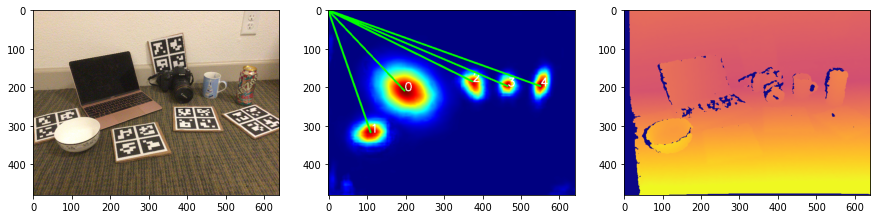

In [14]:
display_gird(img_vis, depth, peak_output)

## 2.2 Decode shape from latent embeddings

In [15]:
write_pcd = False
rotated_pcds = []
points_2d = []
box_obb = []
axes = []
colors_array = []
boxes = []
for j in range(len(latent_emb_outputs)):
    emb = latent_emb_outputs[j]
    emb = latent_emb_outputs[j]
    emb = torch.FloatTensor(emb).unsqueeze(0)
    emb = emb.cuda()
    _, shape_out = ae(None, emb)
    shape_out = shape_out.cpu().detach().numpy()[0]
    rotated_pc, rotated_box, _ = get_gt_pointclouds(abs_pose_outputs[j], shape_out, camera_model = _CAMERA)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(rotated_pc)
    print("rotated_pc", rotated_pc.shape)
    rotated_pcds.append(pcd)
    pcd.paint_uniform_color((1.0, 0.0, 0.0))
    colors_array.append(pcd.colors)
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    T = abs_pose_outputs[j].camera_T_object
    mesh_frame = mesh_frame.transform(T)
    rotated_pcds.append(mesh_frame)
    cylinder_segments = line_set_mesh(rotated_box)
    for k in range(len(cylinder_segments)):
      rotated_pcds.append(cylinder_segments[k])
    points_mesh = camera.convert_points_to_homopoints(rotated_pc.T)
    points_2d_mesh = project(_CAMERA.K_matrix, points_mesh)
    points_2d_mesh = points_2d_mesh.T
    points_2d.append(points_2d_mesh)
    #2D output
    points_obb = camera.convert_points_to_homopoints(np.array(rotated_box).T)
    points_2d_obb = project(_CAMERA.K_matrix, points_obb)
    points_2d_obb = points_2d_obb.T
    box_obb.append(points_2d_obb)
    xyz_axis = 0.3*np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]).transpose()
    sRT = abs_pose_outputs[j].camera_T_object @ abs_pose_outputs[j].scale_matrix
    transformed_axes = transform_coordinates_3d(xyz_axis, sRT)
    projected_axes = calculate_2d_projections(transformed_axes, _CAMERA.K_matrix[:3,:3])
    axes.append(projected_axes)

draw_geometries(rotated_pcds)

rotated_pc (2048, 3)
rotated_pc (2048, 3)
rotated_pc (2048, 3)
rotated_pc (2048, 3)
rotated_pc (2048, 3)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.3 Project 3D Pointclouds and 3D bounding boxes on 2D image

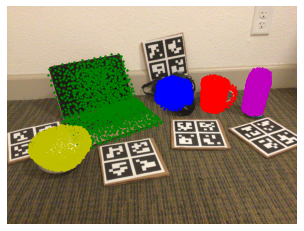

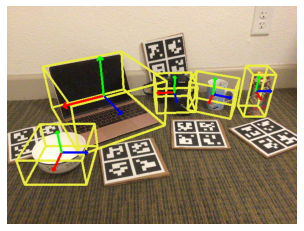

In [16]:
color_img = np.copy(img_vis) 
projected_points_img = show_projected_points(color_img, points_2d)
colors_box = [(63, 237, 234)]
im = np.array(np.copy(img_vis)).copy()
for k in range(len(colors_box)):
    for points_2d, axis in zip(box_obb, axes):
        points_2d = np.array(points_2d)
        im = draw_bboxes(im, points_2d, axis, colors_box[k])

plt.gca().invert_yaxis()
plt.axis('off')
plt.imshow(im[...,::-1])
plt.show()